## Load packages and mount drive

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import time
import os
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, AveragePooling2D
from keras.utils.np_utils import to_categorical 
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam

!pip install -q -U keras-tuner
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

np.random.seed(7)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print('Python version: ', sys.version)
print('TF version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Keras Tuner version: ', kt.__version__)

Python version:  3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
TF version:  2.6.0
Keras version:  2.6.0
Keras Tuner version:  1.0.4


## Preprocessing

In [ ]:
bullish = '/content/drive/MyDrive/5d-forecast-chart-imageset/bullish'
bearish = '/content/drive/MyDrive/5d-forecast-chart-imageset/bearish'

In [ ]:
img_list_bullish, img_list_bearish = [], []

for filename in os.listdir(bullish):
  if filename.endswith('png'):
    img = Image.open(os.path.join(bullish, filename))
    img = ImageOps.grayscale(img)
    img_list_bullish.append(img)


for filename in os.listdir(bearish):
  if filename.endswith('png'):
    img = Image.open(os.path.join(bearish, filename))
    img = ImageOps.grayscale(img)
    img_list_bearish.append(np.array(img))

In [ ]:
print(len(img_list_bullish), len(img_list_bearish))

5394 6606


In [ ]:
type(img_list_bullish[0])

PIL.Image.Image

In [ ]:
# balance datasets

img_list_bullish = [np.array(img) for img in img_list_bullish]
img_list_bearish = [np.array(img) for img in img_list_bearish[:len(img_list_bullish)]]

In [ ]:
print(len(img_list_bullish), len(img_list_bearish))

5394 5394


In [ ]:
X = []

for i in range(len(img_list_bullish)):
  X.append(img_list_bullish[i])

for i in range(len(img_list_bearish)):
  X.append(img_list_bearish[i])

In [ ]:
print(len(X))
print(X[0].shape)

10788
(128, 128)


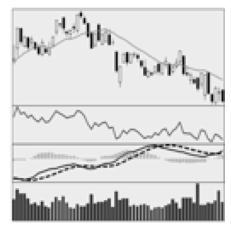

In [ ]:
plt.imshow(X[0], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

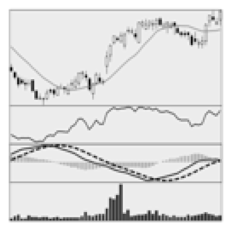

In [ ]:
plt.imshow(X[1042], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [ ]:
X = np.array(X)

In [ ]:
print(X.shape)

(10788, 128, 128)


In [ ]:
X[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 249, ..., 202, 201, 211],
       [255, 255, 235, ..., 210, 210, 177],
       ...,
       [255, 255, 234, ..., 133,  49, 152],
       [255, 255, 249, ..., 201, 198, 211],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:
X = X.astype('float32') / 255.0

print(X.shape)

(10788, 128, 128)


In [ ]:
X[0]

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 0.9764706 , ..., 0.7921569 , 0.7882353 ,
        0.827451  ],
       [1.        , 1.        , 0.92156863, ..., 0.8235294 , 0.8235294 ,
        0.69411767],
       ...,
       [1.        , 1.        , 0.91764706, ..., 0.52156866, 0.19215687,
        0.59607846],
       [1.        , 1.        , 0.9764706 , ..., 0.7882353 , 0.7764706 ,
        0.827451  ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]], dtype=float32)

In [ ]:
y = []

y.append([1]*5394)
y.append([0]*5394)

In [ ]:
y = [label for labels in y for label in labels]

print(len(y))

10788


In [ ]:
y = np.array(y)

In [ ]:
y.shape

(10788,)

In [ ]:
### SAVE X and y arrays ###

# np.save('/content/drive/MyDrive/cnn-data/X.npy', X)
np.save('/content/drive/MyDrive/cnn-data/y.npy', y)


## Use saved X and y arrays from here

In [4]:
X = np.load('/content/drive/MyDrive/cnn-data/X.npy')
y = np.load('/content/drive/MyDrive/cnn-data/y.npy')

In [5]:
print(X.shape, y.shape)

(10788, 128, 128) (10788,)


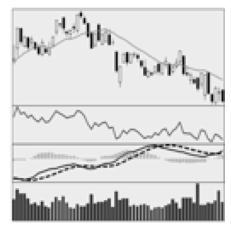

In [6]:
plt.imshow(X[0], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [7]:
y[5390:5400]

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [8]:
# shuffle data

X, y = shuffle(X, y, random_state=99)

In [9]:
# split using sklearn 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=99)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=99)

In [10]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7767, 128, 128) (7767,)
(2158, 128, 128) (2158,)
(863, 128, 128) (863,)


Training Class Split: 3850 bullish, 3917 bearish
Validation Class Split: 1101 bullish, 1057 bearish
Test Class Split: 443 bullish, 420 bearish


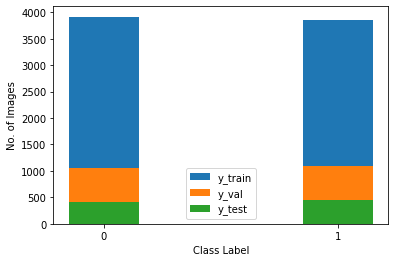

In [11]:
# Check for class imbalance

train_bullish, train_bearish = 0, 0
for label in y_train:
  if label == 0:
    train_bearish += 1
  else:
    train_bullish += 1


val_bullish, val_bearish = 0, 0
for label in y_val:
  if label == 0:
    val_bearish += 1
  else:
    val_bullish += 1


test_bullish, test_bearish = 0, 0
for label in y_test:
  if label == 0:
    test_bearish += 1
  else:
    test_bullish += 1

print(f'Training Class Split: {train_bullish} bullish, {train_bearish} bearish')
print(f'Validation Class Split: {val_bullish} bullish, {val_bearish} bearish')
print(f'Test Class Split: {test_bullish} bullish, {test_bearish} bearish')

fig, ax = plt.subplots()
ax.bar(['0', '1'], [train_bearish, train_bullish], width=0.3, label='y_train')
ax.bar(['0', '1'], [val_bearish, val_bullish], width=0.3, label='y_val')
ax.bar(['0', '1'], [test_bearish, test_bullish], width=0.3, label='y_test')
plt.legend()
plt.xlabel('Class Label')
plt.ylabel('No. of Images')
plt.show()

In [12]:
input_shape = list(X_train.shape[1:])
input_shape.append(1)
input_shape = tuple(input_shape)
input_shape

(128, 128, 1)

In [13]:
X_train = X_train.reshape(-1, 128, 128, 1)
X_val = X_val.reshape(-1, 128, 128, 1)
X_test = X_test.reshape(-1, 128, 128, 1)

In [14]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7767, 128, 128, 1) (7767,)
(2158, 128, 128, 1) (2158,)
(863, 128, 128, 1) (863,)


## Manual CNN Model Tuning

In [29]:
def base_custom_cnn():
  
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Flatten())

  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=opt, loss=loss, metrics=metric)

  return model

In [30]:
opt = Adam(learning_rate=0.001)
loss = 'binary_crossentropy'
metric = ['accuracy']

epochs = 75
batch_size = 2**6  #64

In [31]:
basemodel = base_custom_cnn()
basemodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65537     
Total params: 84,353
Trainable params: 84,353
Non-trainable params: 0
__________________________________________________

In [32]:
history = basemodel.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val))

Epoch 1/75
122/122 [==============================] - 8s 56ms/step - loss: 0.7073 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.4898
Epoch 2/75
122/122 [==============================] - 6s 51ms/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6934 - val_accuracy: 0.4898
Epoch 3/75
122/122 [==============================] - 6s 51ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6932 - val_accuracy: 0.4898
Epoch 4/75
122/122 [==============================] - 6s 51ms/step - loss: 0.6925 - accuracy: 0.5198 - val_loss: 0.6922 - val_accuracy: 0.5213
Epoch 5/75
122/122 [==============================] - 6s 51ms/step - loss: 0.6906 - accuracy: 0.5342 - val_loss: 0.6910 - val_accuracy: 0.5213
Epoch 6/75
122/122 [==============================] - 6s 51ms/step - loss: 0.6899 - accuracy: 0.5353 - val_loss: 0.6911 - val_accuracy: 0.5190
Epoch 7/75
122/122 [==============================] - 6s 51ms/step - loss: 0.6887 - accuracy: 0.5401 - val_loss: 0.6897 - val_accuracy: 0.5185

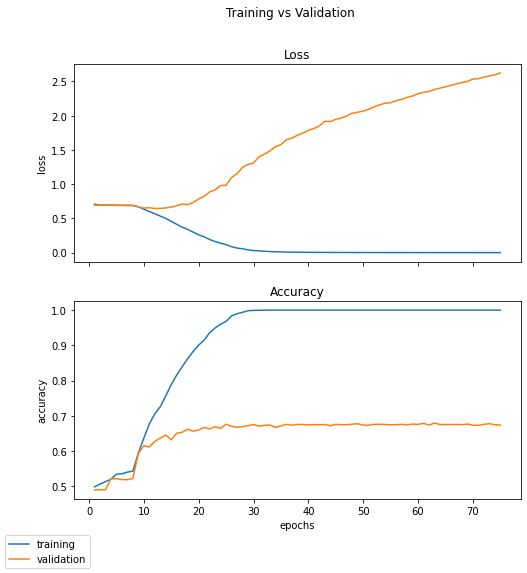

In [33]:
fig, axs = plt.subplots(2, 1, sharex=True, squeeze=False, figsize=(8,8))

axs[0,0].plot(range(1,epochs+1), history.history['loss'], label='training')
axs[0,0].plot(range(1, epochs+1), history.history['val_loss'], label='validation')
axs[0,0].set_ylabel('loss')
axs[0,0].set_title('Loss')

axs[1,0].plot(range(1,epochs+1), history.history['accuracy'])
axs[1,0].plot(range(1, epochs+1), history.history['val_accuracy'])
axs[1,0].set_ylabel('accuracy')
axs[1,0].set_title('Accuracy')

plt.xlabel('epochs')
fig.legend(loc='lower left')
fig.suptitle('Training vs Validation')
plt.show()

In [34]:
# Iterate changes using below template

In [ ]:
def custom_cnn():
  
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Conv2D(32, kernel_size=(2,2), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, kernel_size=(2,2), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(0.25))
  model.add(Flatten())

  model.add(Dense(1000, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
model = custom_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        1

In [ ]:
model.compile(optimizer=opt, loss=loss, metrics=metric)

In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(X_val, y_val))

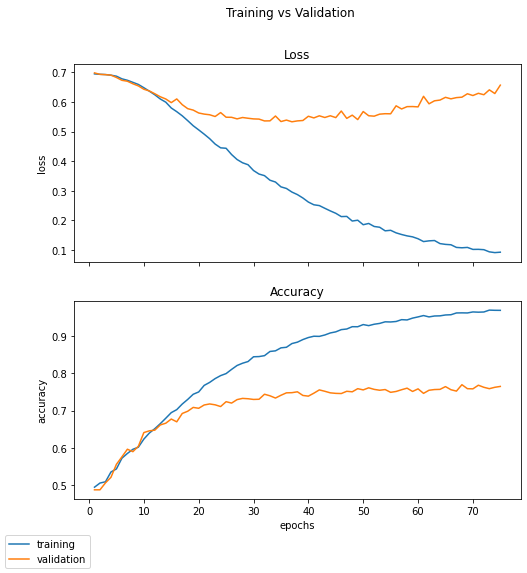

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True, squeeze=False, figsize=(8,8))

axs[0,0].plot(range(1,epochs+1), history.history['loss'], label='training')
axs[0,0].plot(range(1, epochs+1), history.history['val_loss'], label='validation')
axs[0,0].set_ylabel('loss')
axs[0,0].set_title('Loss')

axs[1,0].plot(range(1,epochs+1), history.history['accuracy'])
axs[1,0].plot(range(1, epochs+1), history.history['val_accuracy'])
axs[1,0].set_ylabel('accuracy')
axs[1,0].set_title('Accuracy')

#plt.xticks(range(1,epochs+1))
plt.xlabel('epochs')
fig.legend(loc='lower left')
fig.suptitle('Training vs Validation')
plt.show()

## Manual Model - LetNet5 base

In [ ]:
def lenet_cnn():
  
  model = Sequential()

  model.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), padding='same', activation='tanh', input_shape=input_shape))
  model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), padding='same', activation='tanh', input_shape=input_shape))
  model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), padding='same', activation='tanh', input_shape=input_shape))

  model.add(Flatten())

  model.add(Dense(84, activation='tanh'))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
lenet = lenet_cnn()
lenet.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 128, 128, 6)       156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 64, 64, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 32, 32, 120)       48120     
_________________________________________________________________
flatten_6 (Flatten)          (None, 122880)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 84)               

In [ ]:
lenet.compile(optimizer=opt, loss=loss, metrics=metric)

In [ ]:
history = lenet.fit(X_train, y_train, batch_size=batch_size, epochs=100, verbose=2, validation_data=(X_val, y_val))

In [ ]:
fig, axs = plt.subplots(2, 1, sharex=True, squeeze=False, figsize=(8,8))

axs[0,0].plot(range(1,epochs+1), history.history['loss'], label='training')
axs[0,0].plot(range(1, epochs+1), history.history['val_loss'], label='validation')
axs[0,0].set_ylabel('loss')
axs[0,0].set_title('Loss')

axs[1,0].plot(range(1,epochs+1), history.history['accuracy'])
axs[1,0].plot(range(1, epochs+1), history.history['val_accuracy'])
axs[1,0].set_ylabel('accuracy')
axs[1,0].set_title('Accuracy')

plt.xlabel('epochs')
fig.legend(loc='lower left')
fig.suptitle('Training vs Validation')
plt.show()

## Binary cross entropy and Sigmoid activation

In [ ]:
# with sigmoid and binary crossentropy

# model_b = Sequential()

# model_b.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=X_train.shape[1:]))
# model_b.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# model_b.add(Conv2D(64, kernel_size=(2,2), padding='same', activation='relu'))
# model_b.add(MaxPooling2D(pool_size=(2,2)))

# model_b.add(Dropout(0.25))
# model_b.add(Flatten())

# model_b.add(Dense(1, activation='sigmoid'))
# model_b.summary()

In [ ]:
# print(y_orig_train.shape, y_orig_test.shape)

In [ ]:
# model_b.compile(optimizer=opt, loss='binary_crossentropy', metrics=metric)
# history_b = model_b.fit(X_train, y_orig_train, batch_size=batch_size, epochs=20, verbose=1, validation_data=(X_test, y_orig_test))

In [ ]:
# fig, axs = plt.subplots(2, 1, sharex=True, squeeze=False, figsize=(8,8))

# axs[0,0].plot(range(1,20+1), history_b.history['loss'], label='training')
# axs[0,0].plot(range(1, 20+1), history_b.history['val_loss'], label='validation')
# axs[0,0].set_ylabel('loss')
# axs[0,0].set_title('Loss')

# axs[1,0].plot(range(1,20+1), history_b.history['accuracy'])
# axs[1,0].plot(range(1, 20+1), history_b.history['val_accuracy'])
# axs[1,0].set_ylabel('accuracy')
# axs[1,0].set_title('Accuracy')

# plt.xticks(range(1,20+1))
# plt.xlabel('epochs')
# fig.legend(loc='lower left')
# fig.suptitle('Training vs Validation')
# plt.show()

## Keras Tuner

In [ ]:
LOGDIR = f'{int(time.time())}'

In [ ]:
def build_model(hp):

  model = Sequential()

  model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=128, step=32), kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=(128,128,1)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  for i in range(hp.Int('additional_conv_layers', 1, 3)):
    model.add(Dropout(hp.Choice(f'dropout_layer{i}', [0.0, 0.25, 0.4, 0.5, 0.75])))
    model.add(Conv2D(hp.Int(f'conv_layer{i}_units', 32, 128, 32), kernel_size=(2,2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(hp.Choice('dropout_1', [0.0, 0.25, 0.4, 0.5, 0.75])))
  model.add(Flatten())

  model.add(Dense(hp.Int('dense_units', 100, 1000, 100), activation='relu'))
  model.add(Dropout(hp.Choice('dropout_2', [0.0, 0.25, 0.4, 0.5, 0.75])))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='binary_crossentropy', metrics=['accuracy'])

  return model


In [ ]:
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=20, directory=LOGDIR)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
additional_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
dropout_layer0 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.4, 0.5, 0.75], 'ordered': True}
conv_layer0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
dropout_1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.4, 0.5, 0.75], 'ordered': True}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 1000, 'step': 100, 'sampling': None}
dropout_2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.4, 0.5, 0.75], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

In [ ]:
tuner.search(x=X_train, y=y_train, verbose=2, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[es])

Trial 20 Complete [00h 20m 00s]
val_accuracy: 0.7817423343658447

Best val_accuracy So Far: 0.7817423343658447
Total elapsed time: 02h 34m 42s
INFO:tensorflow:Oracle triggered exit


In [ ]:
print(tuner.results_summary())

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'additional_conv_layers': 2,
 'conv_layer0_units': 64,
 'conv_layer1_units': 64,
 'conv_layer2_units': 32,
 'dense_units': 800,
 'dropout_1': 0.5,
 'dropout_2': 0.25,
 'dropout_layer0': 0.4,
 'dropout_layer1': 0.75,
 'dropout_layer2': 0.5,
 'input_units': 96,
 'learning_rate': 0.0001}

## Recreate Best Model

In [ ]:
def best_model():
  model = Sequential()

  model.add(Conv2D(96, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Dropout(0.4))
  model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(0.75))
  model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2,2), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(800, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
best_model = best_model()
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 96)      2496      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 96)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 63, 63, 64)        24640     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 64)       

In [ ]:
history = best_model.fit(X_train, y_train, batch_size=batch_size, epochs=200, verbose=2, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/200
122/122 - 45s - loss: 0.7240 - accuracy: 0.4844 - val_loss: 0.6932 - val_accuracy: 0.4921
Epoch 2/200
122/122 - 16s - loss: 0.6978 - accuracy: 0.4913 - val_loss: 0.6932 - val_accuracy: 0.4935
Epoch 3/200
122/122 - 16s - loss: 0.6947 - accuracy: 0.5050 - val_loss: 0.6931 - val_accuracy: 0.5056
Epoch 4/200
122/122 - 16s - loss: 0.6943 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5028
Epoch 5/200
122/122 - 16s - loss: 0.6942 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.4898
Epoch 6/200
122/122 - 16s - loss: 0.6941 - accuracy: 0.4938 - val_loss: 0.6931 - val_accuracy: 0.5102
Epoch 7/200
122/122 - 16s - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4898
Epoch 8/200
122/122 - 16s - loss: 0.6925 - accuracy: 0.5151 - val_loss: 0.6931 - val_accuracy: 0.4898
Epoch 9/200
122/122 - 16s - loss: 0.6921 - accuracy: 0.5180 - val_loss: 0.6931 - val_accuracy: 0.5241
Epoch 10/200
122/122 - 16s - loss: 0.6914 - accuracy: 0.5289 - val_loss: 0.6929 - 

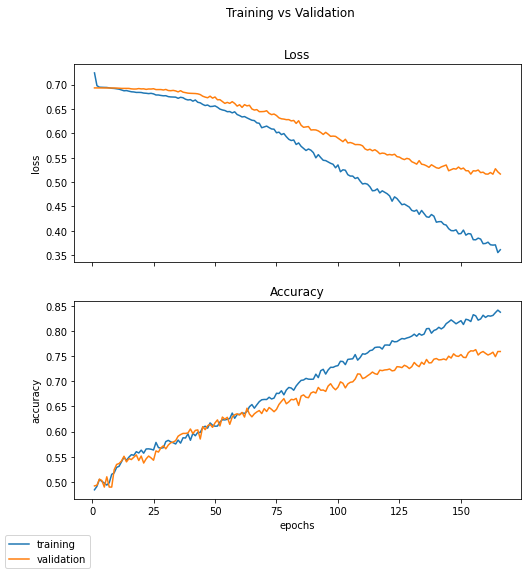

In [ ]:
epochs = 166
fig, axs = plt.subplots(2, 1, sharex=True, squeeze=False, figsize=(8,8))

axs[0,0].plot(range(1,epochs+1), history.history['loss'], label='training')
axs[0,0].plot(range(1, epochs+1), history.history['val_loss'], label='validation')
axs[0,0].set_ylabel('loss')
axs[0,0].set_title('Loss')

axs[1,0].plot(range(1,epochs+1), history.history['accuracy'])
axs[1,0].plot(range(1, epochs+1), history.history['val_accuracy'])
axs[1,0].set_ylabel('accuracy')
axs[1,0].set_title('Accuracy')

plt.xlabel('epochs')
fig.legend(loc='lower left')
fig.suptitle('Training vs Validation')
plt.show()

## save model

In [ ]:
# save model

if os.path.isfile('/content/drive/MyDrive/models/charts-cnn-best-v2.h5') is False:
  best_model.save('/content/drive/MyDrive/models/charts-cnn-best-v2.h5')


In [ ]:
best_from_tuner = load_model('/content/drive/MyDrive/models/charts-cnn-best-v2.h5')

In [ ]:
best_from_tuner.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 96)      2496      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 96)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 63, 64)        24640     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)       

## add LR decay

In [ ]:
def best_with_decay():
  model = Sequential()

  model.add(Conv2D(96, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Dropout(0.4))
  model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(0.75))
  model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2,2), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(800, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0001/100), loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
best_with_decay = best_with_decay()
best_with_decay.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 128, 128, 96)      2496      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 96)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 64, 96)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 63, 63, 64)        24640     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 30, 64)       

In [ ]:
history = best_with_decay.fit(X_train, y_train, batch_size=batch_size, epochs=200, verbose=2, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/200
122/122 - 17s - loss: 0.7230 - accuracy: 0.4934 - val_loss: 0.6932 - val_accuracy: 0.4940
Epoch 2/200
122/122 - 16s - loss: 0.6988 - accuracy: 0.4921 - val_loss: 0.6931 - val_accuracy: 0.5171
Epoch 3/200
122/122 - 16s - loss: 0.6951 - accuracy: 0.4961 - val_loss: 0.6932 - val_accuracy: 0.4903
Epoch 4/200
122/122 - 16s - loss: 0.6938 - accuracy: 0.5060 - val_loss: 0.6931 - val_accuracy: 0.5097
Epoch 5/200
122/122 - 16s - loss: 0.6935 - accuracy: 0.5119 - val_loss: 0.6932 - val_accuracy: 0.4898
Epoch 6/200
122/122 - 16s - loss: 0.6942 - accuracy: 0.5030 - val_loss: 0.6932 - val_accuracy: 0.4898
Epoch 7/200
122/122 - 16s - loss: 0.6936 - accuracy: 0.5038 - val_loss: 0.6931 - val_accuracy: 0.5097
Epoch 8/200
122/122 - 16s - loss: 0.6928 - accuracy: 0.5142 - val_loss: 0.6931 - val_accuracy: 0.5102
Epoch 9/200
122/122 - 16s - loss: 0.6933 - accuracy: 0.5056 - val_loss: 0.6931 - val_accuracy: 0.5171
Epoch 10/200
122/122 - 16s - loss: 0.6938 - accuracy: 0.4971 - val_loss: 0.6932 - 

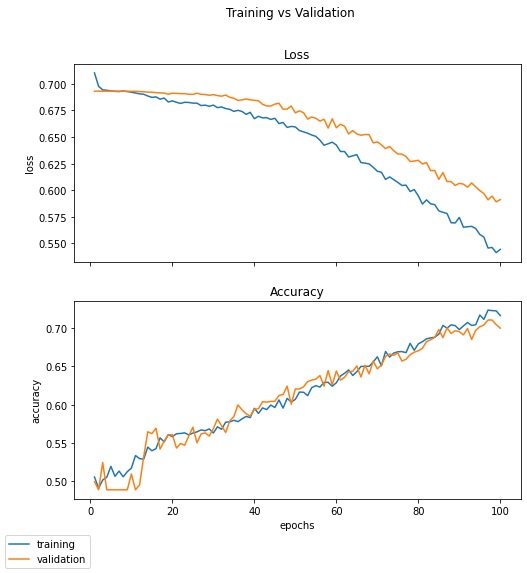

In [ ]:
epochs = 100
fig, axs = plt.subplots(2, 1, sharex=True, squeeze=False, figsize=(8,8))

axs[0,0].plot(range(1,epochs+1), history.history['loss'], label='training')
axs[0,0].plot(range(1, epochs+1), history.history['val_loss'], label='validation')
axs[0,0].set_ylabel('loss')
axs[0,0].set_title('Loss')

axs[1,0].plot(range(1,epochs+1), history.history['accuracy'])
axs[1,0].plot(range(1, epochs+1), history.history['val_accuracy'])
axs[1,0].set_ylabel('accuracy')
axs[1,0].set_title('Accuracy')

plt.xlabel('epochs')
fig.legend(loc='lower left')
fig.suptitle('Training vs Validation')
plt.show()

## with Karpathy LR adjustment

In [ ]:
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow import Variable

In [ ]:
def best_with_karp_decay():
  model = Sequential()

  model.add(Conv2D(96, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  model.add(Dropout(0.4))
  model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(0.75))
  model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(0.5))
  model.add(Conv2D(32, kernel_size=(2,2), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Dropout(0.5))
  model.add(Flatten())

  model.add(Dense(800, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(1, activation='sigmoid'))

  step = Variable(0, trainable=False)
  boundaries = [100*122]   # no. of steps before changing LR
  values = [0.0001, 0.00001]
  learning_rate_fn = PiecewiseConstantDecay(boundaries, values)
  learning_rate = learning_rate_fn(step)

  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
best_with_karp_decay = best_with_karp_decay()
best_with_karp_decay.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 128, 128, 96)      2496      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 96)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 64, 96)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 63, 63, 64)        24640     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 30, 30, 64)       

In [ ]:
history = best_with_karp_decay.fit(X_train, y_train, batch_size=batch_size, epochs=200, verbose=2, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/200
122/122 - 17s - loss: 0.7245 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5088
Epoch 2/200
122/122 - 16s - loss: 0.6979 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5037
Epoch 3/200
122/122 - 16s - loss: 0.6955 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4949
Epoch 4/200
122/122 - 16s - loss: 0.6941 - accuracy: 0.5087 - val_loss: 0.6931 - val_accuracy: 0.5070
Epoch 5/200
122/122 - 16s - loss: 0.6943 - accuracy: 0.4954 - val_loss: 0.6931 - val_accuracy: 0.4930
Epoch 6/200
122/122 - 16s - loss: 0.6939 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4898
Epoch 7/200
122/122 - 16s - loss: 0.6925 - accuracy: 0.5174 - val_loss: 0.6931 - val_accuracy: 0.5227
Epoch 8/200
122/122 - 16s - loss: 0.6920 - accuracy: 0.5191 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 9/200
122/122 - 16s - loss: 0.6916 - accuracy: 0.5231 - val_loss: 0.6930 - val_accuracy: 0.5329
Epoch 10/200
122/122 - 16s - loss: 0.6912 - accuracy: 0.5320 - val_loss: 0.6928 - 

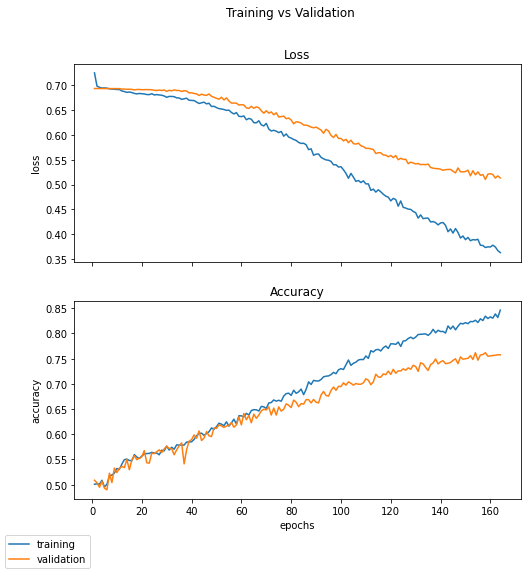

In [ ]:
epochs = 164
fig, axs = plt.subplots(2, 1, sharex=True, squeeze=False, figsize=(8,8))

axs[0,0].plot(range(1,epochs+1), history.history['loss'], label='training')
axs[0,0].plot(range(1, epochs+1), history.history['val_loss'], label='validation')
axs[0,0].set_ylabel('loss')
axs[0,0].set_title('Loss')

axs[1,0].plot(range(1,epochs+1), history.history['accuracy'])
axs[1,0].plot(range(1, epochs+1), history.history['val_accuracy'])
axs[1,0].set_ylabel('accuracy')
axs[1,0].set_title('Accuracy')

plt.xlabel('epochs')
fig.legend(loc='lower left')
fig.suptitle('Training vs Validation')
plt.show()

# Evaluate

In [ ]:
test_score = best_model.evaluate(X_test, y_test)

27/27 [==============================] - 1s 29ms/step - loss: 0.5223 - accuracy: 0.7601


In [ ]:
y_preds = (best_from_tuner.predict(X_test) >= 0.5).astype(int)

In [ ]:
y_preds = np.concatenate(y_preds).ravel()

In [ ]:
y_preds[:10]

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [ ]:
y_test[:10]

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1])

In [ ]:
print(y_test[0], y_preds[0])

0 0


In [ ]:
truth = []
pred = []

for i in range(len(y_test)):
  truth.append(y_test[i])
  pred.append(y_preds[i])

print(len(truth), len(pred))

863 863


In [ ]:
pred[:10]

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]

In [ ]:
print(confusion_matrix(truth, pred))
print('')
print(classification_report(truth, pred))

[[356  64]
 [ 48 395]]

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       420
           1       0.86      0.89      0.88       443

    accuracy                           0.87       863
   macro avg       0.87      0.87      0.87       863
weighted avg       0.87      0.87      0.87       863



In [ ]:
y_preds = best_from_tuner.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
auc_value = auc(fpr, tpr)

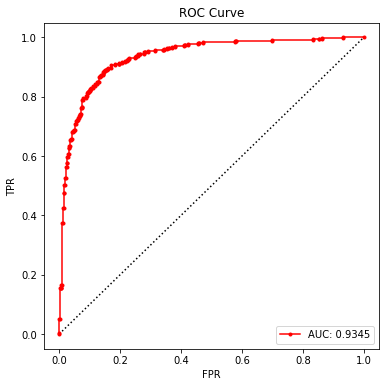

In [ ]:
plt.figure(figsize=(6,6))
plt.plot([0,1], [0,1], color='k', ls='dotted')
plt.plot(fpr, tpr, color='red', marker='.', label=f'AUC: {round(auc_value,4)}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.show()
